<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_absolute_error, make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

## Подготовка

Изучим данные таблицы.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


В таблице мы видим количество заказов за интервал 10 минут. 

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic

In [5]:
taxi.index.is_monotonic

True

Посмотрим границы периода

In [6]:
print(taxi.index.min(), taxi.index.max())

2018-03-01 00:00:00 2018-08-31 23:50:00


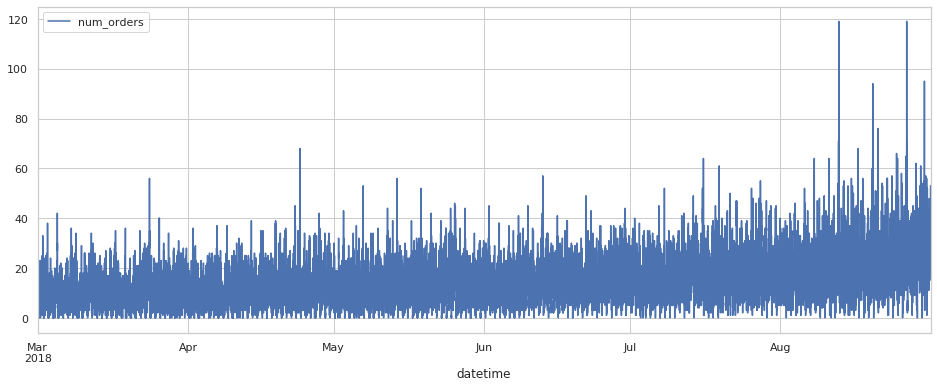

In [7]:
taxi.plot(figsize=(16,6))


## Анализ

Проведем ресемплирование по 1 часу. 

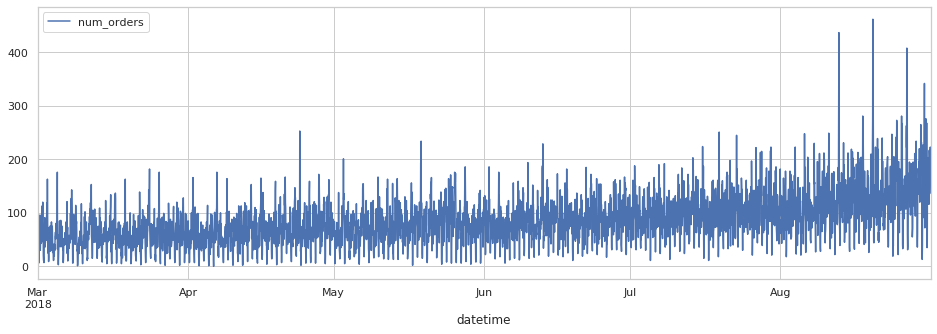

In [8]:
taxi= taxi.resample('1H').sum()
taxi.plot(figsize=(16,5))

In [9]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-block alert-success">
<b>Успех:</b> Ресемплинг был сделан правильно.
</div>

Рассмотрим тренды и сезонность.

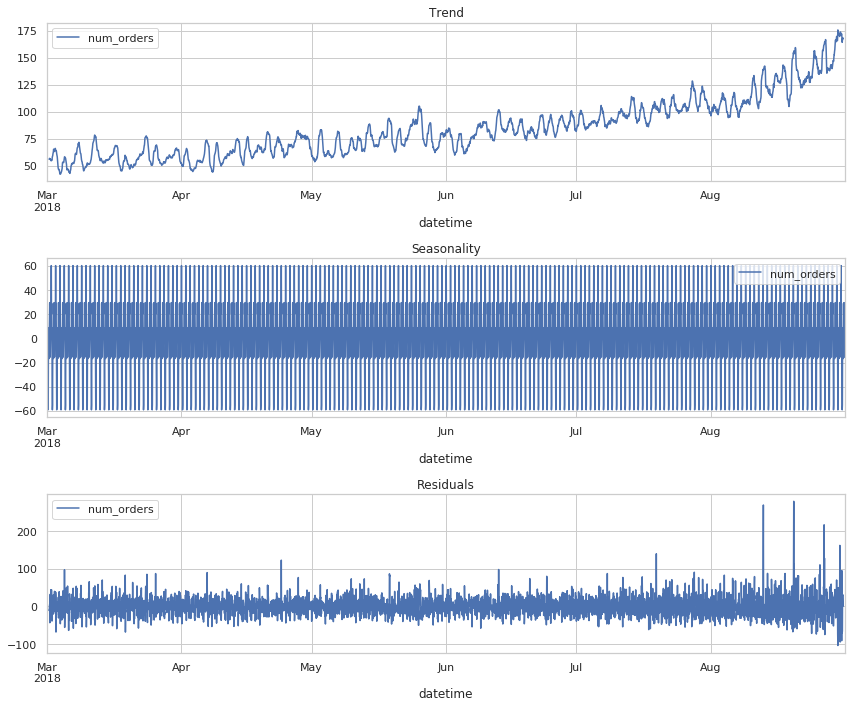

In [10]:
decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд говорит, что объем заказов плавно увеличивается. Сезонности на этом срезе данных не выявлено. Временной ряд не стационарен. 
<br>
Рассмотрим подробнее один месяц

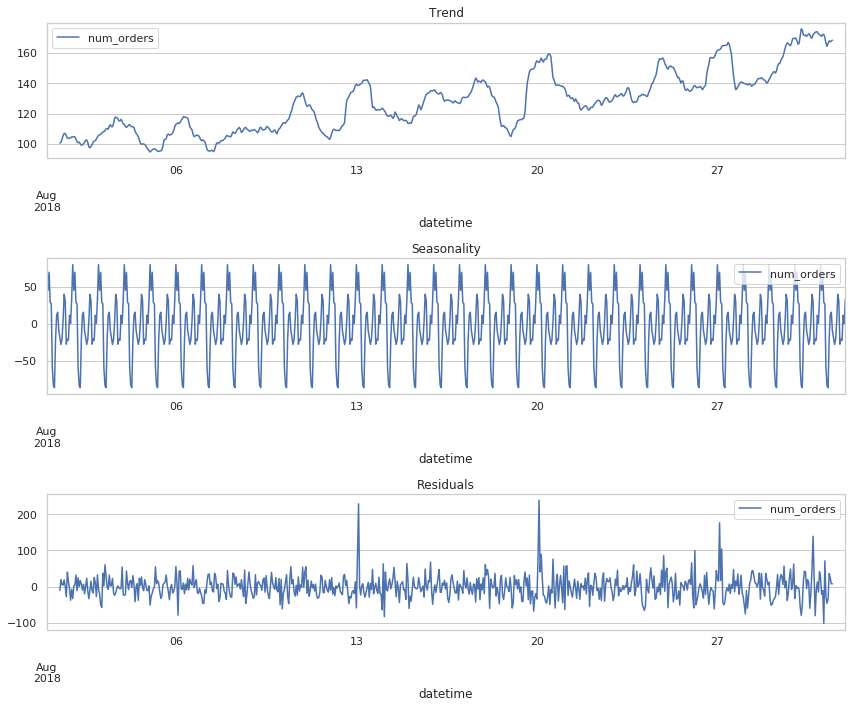

In [11]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31']) 

plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Количество заказов меняется в зависимости от дня недели (13, 20, 27 - понедельники) 

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана корректно. Отлично, что сезонность была визуалиизрована на более коротком интервале.
</div>

Посмотрим на скользящее среднее и стандартное отклонение. 

In [12]:
#taxi.sort_index(inplace=True)
#taxi -= taxi.shift()
taxi['mean'] = taxi['num_orders'].rolling(15).mean()
taxi['std'] = taxi['num_orders'].rolling(15).std()
#taxi.plot(figsize=(12, 10))

## Обучение

Создадим признаки. Для нас имеют значение только день недели и час, более крупные интервалы не показательны. Отстающие значения (max_lag) позже надо будет подобрать. 

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    data['rolling_mean']  = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data  

In [14]:
taxi_copy = make_features(taxi, 12, 12)
taxi_copy.head()

,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(max_lag и rolling_mean_size были подобраны вручную перебором из интервала 8-20)

Разобьем датасет на обучающую и тестовую выборку

In [15]:
train, test = train_test_split(taxi_copy, shuffle=False, test_size=0.1)
train = train.dropna() 

In [16]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 14:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [17]:
print(train.shape)
print(test.shape)

(3960, 18)
(442, 18)


Создадим переменные для признаков и целевого признака.

In [18]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
 

Табличка для записи метрик

In [19]:
d = {'RMSE обучения': [], 'RMSE предсказания':[]}   
          
summary_table = pd.DataFrame(data=d)
def write_summary_table (col, row, rmse):
    if row == 0:
        row = 'RMSE обучения'
    if row == 1:
        row = 'RMSE предсказания'    
    summary_table.loc[col, row] = rmse


### LightGBM ###

Так как ряд временной, для кросс-валидации используем функцию TimeSeriesSplit

In [20]:
split_index = TimeSeriesSplit()

In [21]:
model = LGBMRegressor()

parameters = {
    'objective':['regression'],
    'num_leaves': [2, 12, 2],
    'n_estimators': [50, 100, 150, 200],
    'loss_function': ['RMSE']
    
}

grid_LGBMRegressor = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = split_index)
grid_LGBMRegressor.fit(features_train, target_train)

rms = np.sqrt(-1 *grid_LGBMRegressor.best_score_)

print("RMSE наилучшей модели:", rms)
print(grid_LGBMRegressor.best_params_)
print(grid_LGBMRegressor.best_estimator_)

write_summary_table('LGBMRegressor', 0, rms)

RMSE наилучшей модели: 24.25778893704195
{'loss_function': 'RMSE', 'n_estimators': 200, 'num_leaves': 12, 'objective': 'regression'}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, loss_function='RMSE',
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=12,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


### LinearRegression ###

In [22]:
model = LinearRegression()

parameters = {'n_jobs':[-1]}

grid_LinearRegression = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = split_index)
grid_LinearRegression.fit(features_train, target_train)

rms = np.sqrt(-1 *grid_LinearRegression.best_score_)

print("RMSE наилучшей модели:", rms)
print(grid_LinearRegression.best_params_)
print(grid_LinearRegression.best_estimator_)
write_summary_table('LinearRegression', 0, round(rms, 4))

RMSE наилучшей модели: 28.800818675830538
{'n_jobs': -1}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


### DecisionTreeRegressor ###

In [23]:
model = DecisionTreeRegressor()

parameters = {'max_depth': range(1,16,2)}


grid_DecisionTreeRegressor = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = split_index)
grid_DecisionTreeRegressor.fit(features_train, target_train)


rms = np.sqrt(-1 *grid_DecisionTreeRegressor.best_score_)
print("RMSE наилучшей модели:", rms)
print(grid_DecisionTreeRegressor.best_params_)
print(grid_DecisionTreeRegressor.best_estimator_)

write_summary_table('DecisionTreeRegressor', 0, round(rms, 4))


RMSE наилучшей модели: 31.04869666643998
{'max_depth': 7}
DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


## Тестирование

Проверим все три модели на лучших параметрах

In [24]:
grid_LGBMRegressor.best_estimator_.fit(features_train, target_train)
rms = mean_squared_error(target_test, grid_LGBMRegressor.predict(features_test))  ** 0.5
write_summary_table('LGBMRegressor', 1, rms)

grid_LinearRegression.best_estimator_.fit(features_train, target_train)
rms = mean_squared_error(target_test, grid_LinearRegression.predict(features_test))  ** 0.5
write_summary_table('LinearRegression', 1, rms)

grid_DecisionTreeRegressor.best_estimator_.fit(features_train, target_train)
rms = mean_squared_error(target_test, grid_DecisionTreeRegressor.predict(features_test))  ** 0.5

write_summary_table('DecisionTreeRegressor', 1, rms)


In [25]:
summary_table

,RMSE обучения,RMSE предсказания
LGBMRegressor,24.257789,40.539353
LinearRegression,28.800800,44.412726
DecisionTreeRegressor,31.048700,51.084405


Лучшие результаты получила модель LGBMRegressor. 

Сравним на графике реальное количество заказов и предсказания модели. 

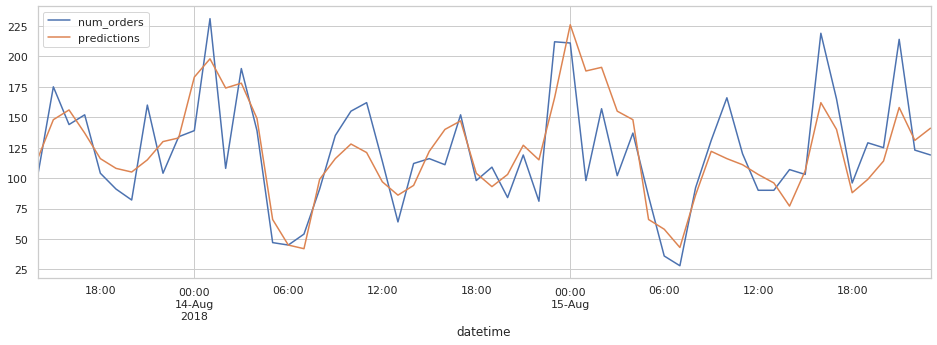

In [26]:
preds  = pd.DataFrame(data = grid_LGBMRegressor.predict(features_test), columns = ['predictions'], index = features_test.index)
graph = pd.merge(target_test, preds, how = 'left', left_index = True, right_index = True)

graph['predictions'] = graph['predictions'].astype('int64')
graph['2018-08-01':'2018-08-15'].plot(figsize=(16,5))


Видно, что наша модель предсказывает адекватно. 

**Вывод**<br>

Мы изучили данные о заказах такси, рассмотрели их тренды и сезонность, ресемплировали по часу, сгладили их и сделали более стационарными, в результате чего стало возможным строить прогноз. 

Были выбраны три модели - LightGBM, линейная регрессия, решающее дерево. 

Лучшие результаты получила модель LightGBM - ее RMSE равно 40 при значениях max_lag и rolling_mean_size 12 и 12. 